In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os




In [2]:
dataset= "cifar10"
run= "19-05"

In [207]:
def get_scores(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="pc" or algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    if algorithm=="full":
        scores= pd.read_csv(run_path +"full.csv", index_col=0)["full_scores"].to_numpy()
    else:
        scores= pd.read_csv(run_path +f"{algorithm}_scores.csv", index_col=0)[f"{algorithm}_scores"].to_numpy()

    return scores.reshape(-1,1)

def get_queries(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="pc" or algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    queries= pd.read_csv(run_path +f"{algorithm}_queries.csv", index_col=0)[f"{algorithm}_queries"].to_numpy()
    return queries.reshape(-1,1)

def get_transition(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    if algorithm=="pc":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    return degrees.reshape(-1,1), options.reshape(-1,1)



In [175]:
def plot_scores(run, dataset, n_epochs, rad, n_seeds, relative= False):
    # Get points for the x axis
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)
    n_eval= len(idx)

    # Get the scores
    pc_scores, random_scores = np.zeros(shape= (n_eval, 0)), np.zeros(shape= (n_eval, 0))
    for sd in np.arange(1, n_seeds+1):
        pc_scores = np.concatenate((pc_scores, get_scores("pc", run, dataset, n_epochs, rad, sd)[:n_eval]), axis=1)
        random_scores = np.concatenate((random_scores, get_scores("random", run, dataset, n_epochs, rad, sd)[:n_eval]), axis=1)
    full_scores = get_scores("full", run, dataset, n_epochs, rad, sd)[:n_eval]
    adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, 1)

    pc_mean, pc_std = pc_scores.mean(1), pc_scores.std(1)
    random_mean, random_std = random_scores.mean(1), random_scores.std(1)
    adpc_mean, adpc_std = adpc_scores.mean(1), adpc_scores.std(1)
    full_scores= full_scores.squeeze()
    m= len(adpc_mean)
    print(m, idx[m-1])
    if relative:
        pc_mean, random_mean, adpc_mean = pc_mean[:m]-full_scores[:m], random_mean[:m]-full_scores[:m],\
                                          adpc_mean-full_scores[:m]
        pc_std, random_std = pc_std[:m], random_std[:m]
        idx = idx[:m]


    plt.plot(idx, random_mean, color= "green", label= "Random")
    plt.fill_between(idx, random_mean-random_std, random_mean+random_std, alpha=0.5, color= "green")

    plt.plot(idx, pc_mean, color= "blue", label= "PC")
    plt.fill_between(idx, pc_mean-pc_std, pc_mean+pc_std, alpha=0.5, color= "blue")

    plt.plot(idx, adpc_mean, color= "red", label= "Adaptive PC")
    plt.fill_between(idx, adpc_mean-adpc_std, adpc_mean+adpc_std, alpha=0.5, color= "red")
    if not relative:
        plt.plot(idx, full_scores, label= "Oracle")


In [240]:
# Check that all of the runs were completed for the benchmarks
for sd in [1,2,3,4,5,6,7,8,9,10]:
    for n_epochs in [100, 200, 400, 800, 1000]:
        adpc_scores = get_scores("pc", run, dataset, n_epochs, 0.0, sd)
        if len(adpc_scores)<315:
            print(n_epochs, sd, len(adpc_scores))

FileNotFoundError: [Errno 2] No such file or directory: './test/cifar10/100_4_0.0_1/pc_scores.csv'

In [244]:
# Check that all of the runs were completed for the adaptive runs
run= "19-05"
for rad in [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    for n_epochs in [100,200,400,800,1000]:
        adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, 1)
        if len(adpc_scores)<305:
            adpc_queries = get_queries("adpc", run, dataset, n_epochs, rad, 1)
            print(n_epochs, rad, len(adpc_scores), len(adpc_queries))
        elif len(adpc_scores)==305:
            a= get_scores("adpc", run, dataset, n_epochs, rad, sd)
            run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
            b= pd.read_csv(run_path +f"pc_scores.csv", index_col=0)[f"pc_scores"].to_numpy()
            # print(np.all(a.squeeze()==b.squeeze()))
            deg1, options1= get_transition("adpc", run, dataset, n_epochs, rad, sd)
            df= pd.read_csv(run_path +f"pc_degrees.csv", index_col=0)
            degrees= df[f"pc_degrees"].to_numpy()
            options=df[f"pc_options"].to_numpy()
            # print(np.all(degrees.squeeze()==deg1.squeeze()))
            # print(np.all(options.squeeze()==options1.squeeze()))
            radiuses1= pd.read_csv(run_path +f"pc_radiuses.csv", index_col=0).to_numpy()
            radiuses2= pd.read_csv(run_path +f"adpc_radiuses.csv", index_col=0).to_numpy()
            # print(np.all(radiuses1.squeeze()==radiuses2.squeeze()))



100 0.8 302 13600
100 0.85 272 5700
200 0.85 303 14400
100 0.9 243 2800
200 0.9 285 8100
400 0.9 296 10600
100 1.0 215 1000
200 1.0 225 1500
400 1.0 238 2300
800 1.0 293 9700
1000 1.0 303 14000


In [242]:
# Check that all of the runs were completed for the adaptive runs
run= "test"
rad= 0.55
n_epochs=100
adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, 1)
adpc_queries = get_queries("adpc", run, dataset, n_epochs, rad, 1)
print(n_epochs, rad, len(adpc_scores), len(adpc_queries))
a= get_scores("adpc", run, dataset, n_epochs, rad, sd)
run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
b= pd.read_csv(run_path +f"pc_scores.csv", index_col=0)[f"pc_scores"].to_numpy()
print(np.all(a.squeeze()==b.squeeze()))
deg1, options1= get_transition("adpc", run, dataset, n_epochs, rad, sd)
df= pd.read_csv(run_path +f"pc_degrees.csv", index_col=0)
degrees= df[f"pc_degrees"].to_numpy()
options=df[f"pc_options"].to_numpy()
print(np.all(degrees.squeeze()==deg1.squeeze()))
print(np.all(options.squeeze()==options1.squeeze()))
radiuses1= pd.read_csv(run_path +f"pc_radiuses.csv", index_col=0).to_numpy()
radiuses2= pd.read_csv(run_path +f"adpc_radiuses.csv", index_col=0).to_numpy()
print(np.all(radiuses1.squeeze()==radiuses2.squeeze()))



100 0.55 190 500


FileNotFoundError: [Errno 2] No such file or directory: './test/cifar10/100_4_0.55_1/pc_scores.csv'

305 15000


(-0.2, 0.0)

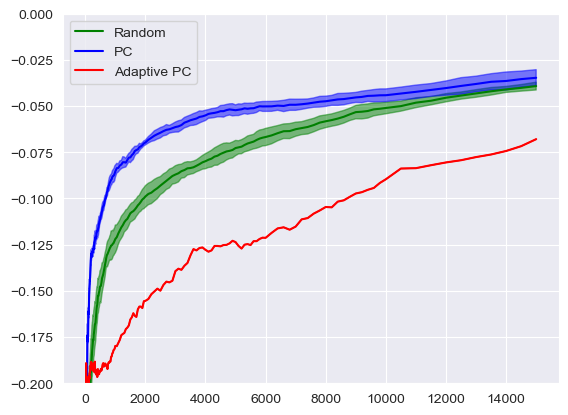

In [192]:
plot_scores(run, dataset, 100, 0.7, 10, True)
plt.legend()
plt.ylim(-0.2, 0)

In [ ]:
b= pd.read_csv(run_path +f"pc_scores.csv", index_col=0)[f"pc_scores"].to_numpy()

In [65]:
print(a.shape, b.shape, c.shape, d.shape)

(305, 10) (305, 10) (305, 1) (305, 1)


In [24]:
def get_scores(gauss, rad, std):
    adpc = np.zeros(shape= (5000, 0))
    pc = np.zeros(shape= (5000, 0))
    random = np.zeros(shape= (5000, 0))

    # Get the scores
    for sd in np.arange(1,11):
        path_adpc= f"/Users/victoriabarenne//runs-01-05/linear_500_{std}_{gauss}_0.95_{rad}_1_{sd}/"
        path= f"/Users/victoriabarenne/{run}/runs-01-05/linear_500_{std}_{gauss}_0.95_0.0_1_{sd}/"
        adpc = np.concatenate((adpc,np.array(pd.read_csv(path_adpc+"adaptive_pc.csv", index_col=0).adpc_scores).reshape(-1,1)), axis=1)
        pc = np.concatenate((pc, np.array(pd.read_csv(path+"pc.csv", index_col=0).pc_scores).reshape(-1,1)), axis=1)
        random = np.concatenate((random, np.array(pd.read_csv(path+"random.csv", index_col=0).random_scores).reshape(-1,1)), axis=1)
    full = np.array(pd.read_csv(path+"full.csv", index_col=0).full_scores)
    return adpc, pc, random, full

def plot_results(gauss, rad, std, idx=None):
    adpc, pc, random, full = get_scores(gauss, rad, std)

    if idx is None:
        idx= np.arange(len(adpc))

    plt.plot(idx, adpc.mean(axis=1), color= "red", label= "Adaptive PC")
    plt.fill_between(idx, adpc.mean(axis=1)-adpc.std(axis=1), adpc.mean(axis=1)+adpc.std(axis=1), alpha=0.5, color= "red")
    plt.plot(idx, pc.mean(axis=1), color= "blue", label= "PC")
    plt.fill_between(idx, pc.mean(axis=1)-pc.std(axis=1), pc.mean(axis=1)+pc.std(axis=1), alpha=0.5, color= "blue")

    plt.plot(idx, random.mean(axis=1), color= "green", label= "Random")
    plt.fill_between(idx, random.mean(axis=1)-random.std(axis=1), random.mean(axis=1)+random.std(axis=1), alpha=0.5, color= "green")

    plt.plot(idx, full, label= "full")

def plot_results_relative(gauss, rad, std, idx=None):
    adpc, pc, random, full = get_scores(gauss, rad, std)

    if idx is None:
        idx= np.arange(len(adpc))

    plt.plot(idx, adpc.mean(axis=1)-full, color= "red", label= "Adaptive PC")
    plt.fill_between(idx, adpc.mean(axis=1)-full-adpc.std(axis=1), adpc.mean(axis=1)-full+adpc.std(axis=1),
                     alpha=0.5, color= "red")
    plt.plot(idx, pc.mean(axis=1)-full, color= "blue", label= "PC")
    plt.fill_between(idx, pc.mean(axis=1)-full-pc.std(axis=1), pc.mean(axis=1)-full+pc.std(axis=1),
                     alpha=0.5, color= "blue")
    plt.plot(idx, random.mean(axis=1)-full, color= "green", label= "Random")
    plt.fill_between(idx, random.mean(axis=1)-full-random.std(axis=1), random.mean(axis=1)-full+random.std(axis=1),
                     alpha=0.5, color= "green")


In [11]:
def check_runs(dir, type, gauss, radiuses, stds, sds):
    # Check that all of the runs exist
    count=0
    for g in gauss:
        for std in stds:
            for sd in sds:
                for rad in radiuses:
                    path = f"/Users/victoriabarenne/thesis3/{dir}/{type}_500_{std}_{g}_0.95_{rad}_1_{sd}/"
                    if not os.path.exists(path):
                        print(path)
                        count+=1
    print(count)

# Checking Gauss degrees for linearly separable



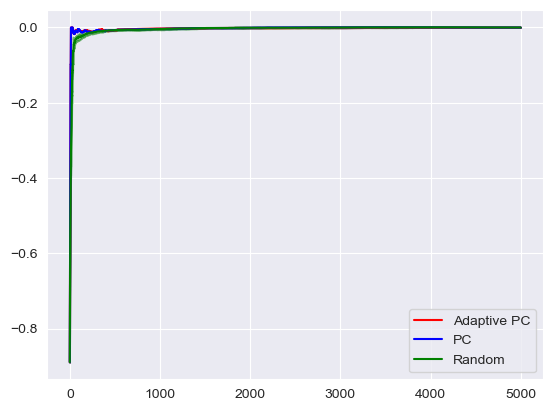

In [15]:
dir= "runs-01-05"
std= 0.3
gauss= 1
rad= 0.0

plot_results_relative(gauss, rad, std)
plt.legend()
plt.show()

In [26]:
linear= True
dir= "runs-01-05"

gauss = [1,2,3,4]
radiuses = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0]
seeds = [1,2,3,4,5,6,7,8,9,10]

if linear:
        stds= [0.1, 0.2, 0.3, 0.4, 0.5]
else:
    stds= [0.2, 0.3, 0.4, 0.5]



In [ ]:



for std in [0.4]:
    for gauss in [4]:
        for rad in [0.2, 0.3 ,0.6, 1.0, 1.5]:



            plot_results_relative(adpc, pc, random, full)
            plt.title(f"std {std} gauss {gauss} rad {rad}")
            plt.legend()
            plt.xlim(0,1000)
            plt.ylim(-0.15, 0.01)
            plt.show()

In [4]:

from IPython import embed
rad=0.0
for std in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gauss in [1,2,4,8]:
        adpc = np.zeros(shape= (5000,))
        pc = np.zeros(shape= (5000,))
        random = np.zeros(shape= (5000,))
        for sd in range(1,11):
            path= f"/Users/victoriabarenne/thesis3/runs-01-05/linear_500_{std}_{gauss}_0.95_{rad}_1_{sd}/"
            if not os.path.exists(path):
                print(path)




